In [ ]:
import pandas as pd

orders = pd.read_csv("orders.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
products = pd.read_csv("products.csv")

In [ ]:
# Display sample data
print("\nOrders Data:")
print(orders.head())

print("\nOrder Products Data:")
print(order_products_prior.head())

print("\nProducts Data:")
print(products.head())


Orders Data:
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329      1.0    prior           1.0        2.0                8.0   
1   2398795      1.0    prior           2.0        3.0                7.0   
2    473747      1.0    prior           3.0        3.0               12.0   
3   2254736      1.0    prior           4.0        4.0                7.0   
4    431534      1.0    prior           5.0        4.0               15.0   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  

Order Products Data:
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                1.0        1.0
1         2       28985                2.0        1.0
2         2        9327                3.0        0.0
3         2       45918                4.0        1.0
4         2       30035                5.0        0.0

Products

In [ ]:
# Merge order products with orders on order_id
df = order_products_prior.merge(orders[['order_id', 'order_dow', 'order_hour_of_day']], on="order_id", how="left")

print("\nMerged Orders and Products Data:")
print(df.head())


Merged Orders and Products Data:
   order_id  product_id  add_to_cart_order  reordered  order_dow  \
0         2       33120                1.0        1.0        NaN   
1         2       28985                2.0        1.0        NaN   
2         2        9327                3.0        0.0        NaN   
3         2       45918                4.0        1.0        NaN   
4         2       30035                5.0        0.0        NaN   

   order_hour_of_day  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  


In [ ]:
# Merge with products to get product names and aisle info
df = df.merge(products[['product_id', 'product_name']], on="product_id", how="left")

print("\nFinal Merged Data:")
print(df.head())


Final Merged Data:
   order_id  product_id  add_to_cart_order  reordered  order_dow  \
0         2       33120                1.0        1.0        NaN   
1         2       28985                2.0        1.0        NaN   
2         2        9327                3.0        0.0        NaN   
3         2       45918                4.0        1.0        NaN   
4         2       30035                5.0        0.0        NaN   

   order_hour_of_day           product_name  
0                NaN     Organic Egg Whites  
1                NaN  Michigan Organic Kale  
2                NaN          Garlic Powder  
3                NaN         Coconut Butter  
4                NaN      Natural Sweetener  


In [ ]:
# Aggregate order counts per product per day and hour
inventory_data = df.groupby(["product_id", "order_dow", "order_hour_of_day"])\
                   .size()\
                   .reset_index(name="order_count")

print("\nAggregated Inventory Data:")
print(inventory_data.head())


Aggregated Inventory Data:
   product_id  order_dow  order_hour_of_day  order_count
0           1        2.0                7.0            1
1          12        1.0               22.0            1
2          23        3.0               13.0            1
3          25        4.0               12.0            1
4          28        0.0                8.0            1


In [ ]:
split_ratio = 0.8
split_index = int(len(inventory_data) * split_ratio)

train_data = inventory_data[:split_index]  # Training Data
test_data = inventory_data[split_index:]

In [ ]:
import numpy as np
import gym
from gym import spaces

In [ ]:
class InstacartInventoryEnv(gym.Env):
    def __init__(self, df, max_inventory=500):
        super(InstacartInventoryEnv, self).__init__()
        self.df = df
        self.max_inventory = max_inventory
        self.current_step = 0
        self.inventory_level = max_inventory // 2  # Start at 50% stock

        # Define action space (0: Order More, 1: Hold, 2: Reduce)
        self.action_space = spaces.Discrete(3)

        # Define state space (Inventory, past sales, day, hour)
        self.observation_space = spaces.Box(low=0, high=1000, shape=(4,), dtype=np.float32)

    def step(self, action):
        # Extract order trends (demand)
        orders_today = self.df.iloc[self.current_step]["order_count"]
        day_of_week = self.df.iloc[self.current_step]["order_dow"]
        hour_of_day = self.df.iloc[self.current_step]["order_hour_of_day"]

        # Update inventory based on action
        if action == 0:  # Order More Stock
            self.inventory_level = min(self.inventory_level + 30, self.max_inventory)
        elif action == 2:  # Reduce Stock
            self.inventory_level = max(self.inventory_level - 30, 0)

        # Simulate sales (reduce inventory)
        self.inventory_level = max(self.inventory_level - orders_today, 0)

        # Reward: Revenue - Holding Cost
        revenue = orders_today * 10
        holding_cost = self.inventory_level * 0.1
        reward = revenue - holding_cost

        # Move to the next time step
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        return np.array([self.inventory_level, orders_today, day_of_week, hour_of_day]), reward, done, {}

    def reset(self):
        self.current_step = 0
        self.inventory_level = self.max_inventory // 2
        return np.array([self.inventory_level, 0, 0, 0])


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayMemory(2000)
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        self.epsilon = 1.0  # Exploration rate

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state_tensor = torch.tensor(state, dtype=torch.float32)
        q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

    def train(self):
        if len(self.memory) < 32:
            return
        batch = self.memory.sample(32)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model(next_states).max(1)[0].detach()
        target_q_values = rewards + (0.99 * next_q_values * (1 - dones))

        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


In [ ]:
from collections import deque
env = InstacartInventoryEnv(train_data)
agent = DQNAgent(state_size=4, action_size=3)

Episode 1: Total Reward = 317.49999999999994
Episode 2: Total Reward = -1417.6000000000001
Episode 3: Total Reward = -1397.5
Episode 4: Total Reward = -1331.5
Episode 5: Total Reward = 261.0
Episode 6: Total Reward = 494.20000000000005
Episode 7: Total Reward = -1340.5000000000002
Episode 8: Total Reward = -2060.5000000000005
Episode 9: Total Reward = -1064.5
Episode 10: Total Reward = -1538.5
Episode 11: Total Reward = -262.29999999999995
Episode 12: Total Reward = -15.399999999999974
Episode 13: Total Reward = -159.50000000000009
Episode 14: Total Reward = 628.1
Episode 15: Total Reward = 147.89999999999998
Episode 16: Total Reward = -321.8999999999999
Episode 17: Total Reward = -112.59999999999997
Episode 18: Total Reward = 142.39999999999995
Episode 19: Total Reward = -171.50000000000003
Episode 20: Total Reward = 386.4000000000001
Episode 21: Total Reward = 371.3
Episode 22: Total Reward = -230.20000000000005
Episode 23: Total Reward = 102.59999999999997
Episode 24: Total Reward =

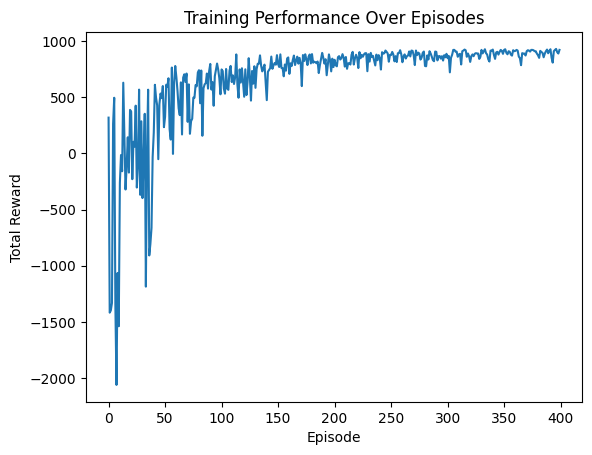

In [ ]:
num_episodes = 400
reward_history = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for t in range(100):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.memory.push(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward

        if done:
            break

    if episode % 10 == 0:
        agent.update_target_model()

    agent.epsilon = max(0.01, agent.epsilon * 0.995)
    reward_history.append(total_reward)
    print(f"Episode {episode+1}: Total Reward = {total_reward}")

print("Training Complete!")

plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance Over Episodes")
plt.show()


In [ ]:
test_env = InstacartInventoryEnv(test_data)

# Test RL Agent
state = test_env.reset()
total_reward_rl = sum(test_env.step(agent.act(state))[1] for _ in range(100))

# Test Rule-Based Model
state = test_env.reset()
total_reward_rule_based = sum(test_env.step(0 if state[0] < 100 else 2 if state[0] > 400 else 1)[1] for _ in range(100))

print(f"\nRL Model Reward: {total_reward_rl}")
print(f"Rule-Based Model Reward: {total_reward_rule_based}")



RL Model Reward: 924.2
Rule-Based Model Reward: -956.5


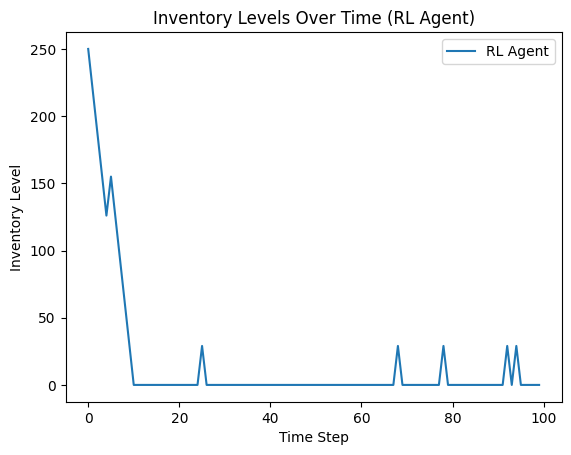

In [ ]:
inventory_rl = []
state = test_env.reset()

for t in range(100):
    action = agent.act(state)
    next_state, reward, done, _ = test_env.step(action)
    inventory_rl.append(state[0])  # Save inventory level
    state = next_state
    if done:
        break

# Plot inventory trend
plt.plot(inventory_rl, label="RL Agent")
plt.xlabel("Time Step")
plt.ylabel("Inventory Level")
plt.title("Inventory Levels Over Time (RL Agent)")
plt.legend()
plt.show()


In [47]:
# Reset the test environment
state = test_env.reset()

# Track stockouts per product
stockout_tracker = {}

# Simulate RL agent's decisions
for t in range(100):
    action = agent.act(state)  # Get RL agent's decision
    next_state, reward, done, _ = test_env.step(action)

    product_id = int(state[0])

    # Track how often each product goes out of stock
    if product_id not in stockout_tracker:
        stockout_tracker[product_id] = 0
    if state[0] == 0:  # Stockout occurred
        stockout_tracker[product_id] += 1

    state = next_state
    if done:
        break

stockout_tracker = pd.DataFrame(list(stockout_tracker.items()), columns=["product_id", "stockout_count"])

stockout_tracker = stockout_tracker.merge(products[['product_id', 'product_name']], on="product_id", how="left")

stockout_tracker = stockout_tracker[stockout_tracker["product_id"] != 0]

print("\nTop 10 Products That Frequently Ran Out of Stock During RL Testing (Filtered):")
print(stockout_tracker.sort_values(by="stockout_count", ascending=False).head(10))


Top 10 Products That Frequently Ran Out of Stock During RL Testing (Filtered):
   product_id  stockout_count  \
0         250               0   
1         219               0   
2         188               0   
3         157               0   
4         126               0   
5          95               0   
6          64               0   
7          33               0   
8          32               0   
9           1               0   

                                        product_name  
0        Authentic Deep Dish, Spinach & Garlic Pizza  
1              Totz Toothbrush Extra Soft 18+ Months  
2                                 Mild El Nino Salsa  
3                            Living Organic Cilantro  
4           Hot & Spicy Chicken Flavor Ramen Noodles  
5                               Organic Rice Vinegar  
6  Autumn Vegetable & Turkey Dinner with Lil' Bit...  
7                      Organic Spaghetti Style Pasta  
8                      Nacho Cheese White Bean Chips  
9     